# Data Visualization - Notebook 2
## Exploring Dataset Characteristics

- Image size distribution
- Class label distribution
- Sample images from each class


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm
import random

In [3]:
# Seting matplotlib style
plt.style.use('ggplot')

# Paths
projectRoot = Path().resolve().parent
datasetPath = projectRoot / "CV2024_CW_Dataset"

trainImagePath = datasetPath / "train" / "images"
trainLabelPath = datasetPath / "train" / "labels"
testImagePath = datasetPath / "test" / "images"
testLabelPath = datasetPath / "test" / "labels"

trainImages = sorted(os.listdir(trainImagePath))
testImages = sorted(os.listdir(testImagePath))

print("Dataset paths set up correctly.")

Dataset paths set up correctly.


## Image Size Distribution/Analysis


 ... (more hidden) ...
 ... (more hidden) ...


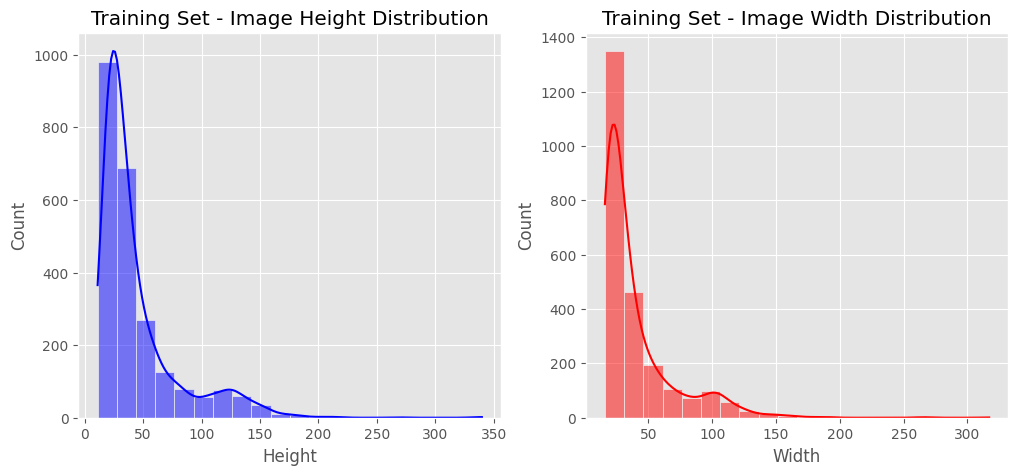

In [5]:
def getImageSizes(imageFolder, imageList):
    sizes = []
    
    for imageName in tqdm(imageList, desc="Extracting image sizes"):
        imagePath = os.path.join(imageFolder, imageName)
        image = cv2.imread(imagePath)
        
        if image is not None:
            sizes.append(image.shape[:2])  # (height, width)
    
    return sizes

# Get sizes for train/test images
trainSizes = getImageSizes(trainImagePath, trainImages)
testSizes = getImageSizes(testImagePath, testImages)

# Convert to DataFrame for plotting
trainSizeDF = pd.DataFrame(trainSizes, columns=["Height", "Width"])
testSizeDF = pd.DataFrame(testSizes, columns=["Height", "Width"])

# Plot image size distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(trainSizeDF["Height"], bins=20, kde=True, ax=axes[0], color="blue")
sns.histplot(trainSizeDF["Width"], bins=20, kde=True, ax=axes[1], color="red")

axes[0].set_title("Training Set - Image Height Distribution")
axes[1].set_title("Training Set - Image Width Distribution")

plt.show()


## Observations on image sizes

- There is significant variation in image size
- Some images are very small while others are much larger
- confirtming we need consistent resizing with padding to avoid distortions

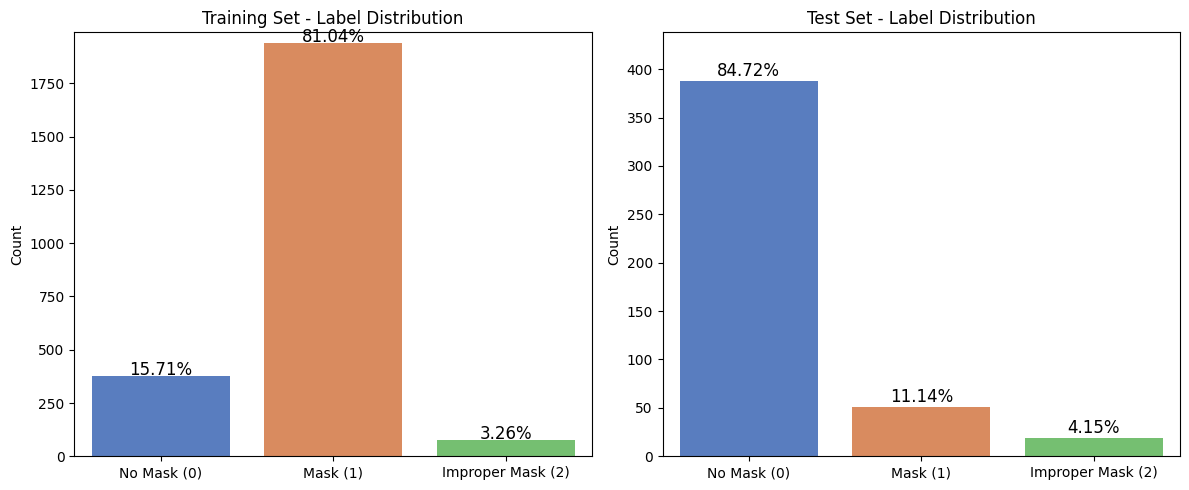

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# label counts from notebook 1
trainLabelCounts = {0: 376, 1: 1940, 2: 78}
testLabelCounts = {0: 388, 1: 51, 2: 19}

#class lavbels
labels = ["No Mask (0)", "Mask (1)", "Improper Mask (2)"]

# training values
trainValues = [trainLabelCounts[0], trainLabelCounts[1], trainLabelCounts[2]]
trainPercentages = [v / sum(trainValues) * 100 for v in trainValues]

# Test values
testValues = [testLabelCounts[0], testLabelCounts[1], testLabelCounts[2]]
testPercentages = [v / sum(testValues) * 100 for v in testValues]

# side by side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set plot
sns.barplot(x=labels, y=trainValues, ax=axes[0], hue=labels, dodge=False, legend=False, palette="muted")
for i, v in enumerate(trainValues):
    axes[0].text(i, v + 5, f"{trainPercentages[i]:.2f}%", ha='center', fontsize=12)
axes[0].set_title("Training Set - Label Distribution")
axes[0].set_ylabel("Count")
axes[0].set_ylim(0, max(trainValues) + 50)

# Test set plot
sns.barplot(x=labels, y=testValues, ax=axes[1], hue=labels, dodge=False, legend=False, palette="muted")
for i, v in enumerate(testValues):
    axes[1].text(i, v + 5, f"{testPercentages[i]:.2f}%", ha='center', fontsize=12)
axes[1].set_title("Test Set - Label Distribution")
axes[1].set_ylabel("Count")
axes[1].set_ylim(0, max(testValues) + 50)

plt.tight_layout()
plt.show()


## Label Distribution Analysis

### Key Observations:
- **Training set is highly imbalanced**
- **Test set distribution is inconsistent with training data**
- The **underrepresentation of Improper Mask (2) in both sets** could negatively impact model performance for this class

### Implications for Model Training:
- **Model may become biased** toward dominant class
- **Generalization may suffer** because of the mismatch between training and test distribution
- **Data balancing techniques** will look into augmentation/resampling



## Displaying Sample Images


In [11]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def selectAndDisplayImages(imageFolder, labelFolder, numSamples=3):
    labels = {0: "No Mask", 1: "Mask", 2: "Improper Mask"}
    classSamples = {0: [], 1: [], 2: []}
    
    # getting all label files and shuffiling for random
    labelFiles = os.listdir(labelFolder)
    random.shuffle(labelFiles)  # Shuffle to randomize selection order

    # randomly select img
    for labelFile in labelFiles:
        labelPath = os.path.join(labelFolder, labelFile)
        imageFile = labelFile.replace(".txt", ".jpeg")
        imagePath = os.path.join(imageFolder, imageFile)

        with open(labelPath, "r") as file:
            label = int(file.read().strip())

        if label in classSamples and len(classSamples[label]) < numSamples:
            classSamples[label].append(imagePath)

        # stop if we have enough samples for all classes
        if all(len(classSamples[l]) == numSamples for l in [0, 1, 2]):
            break  

    # set up figure
    fig, axes = plt.subplots(numSamples, 3, figsize=(9, numSamples * 3))

    for i in range(numSamples):
        for label in [0, 1, 2]:
            img = cv2.imread(classSamples[label][i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for correct display

            axes[i, label].imshow(img)
            axes[i, label].axis("off")
            if i == 0:
                axes[i, label].set_title(labels[label])  # Set class title only for the top row

    plt.tight_layout()
    plt.show()


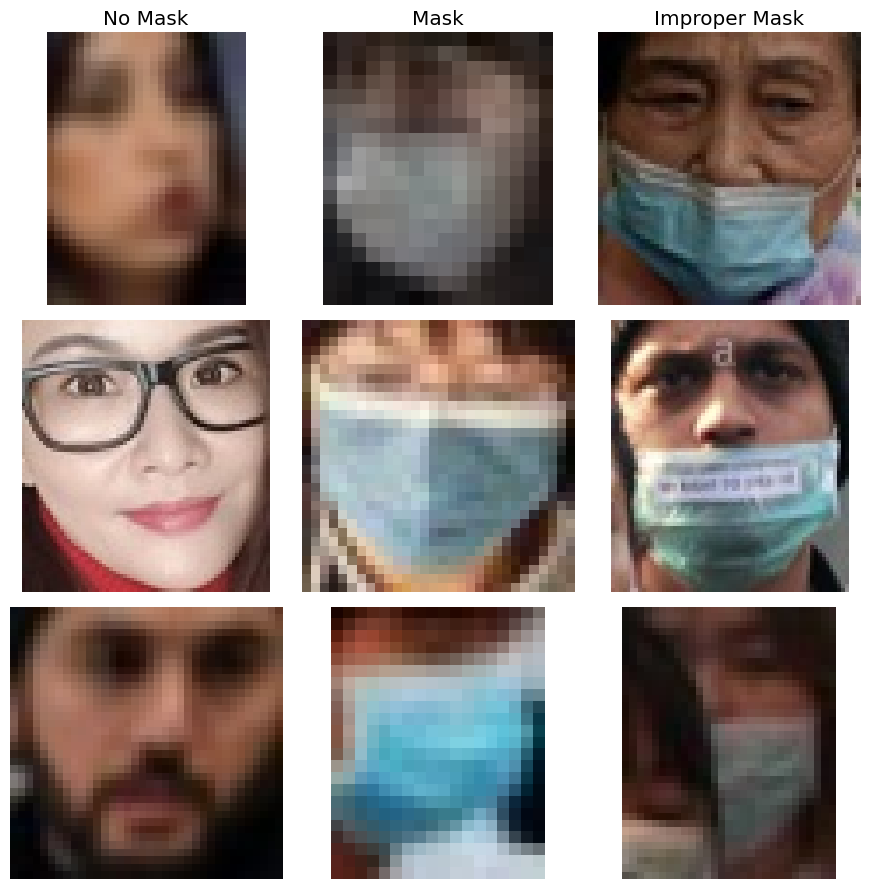

In [13]:
selectAndDisplayImages(trainImagePath, trainLabelPath, numSamples=3)


## Sample Images from Each Class

### Overview
Grid displays randomly selected imgs from all classes:
- **No Mask (0)**: No face mask at all
- **Mask (1)**: correctly worn face masks covering mouth/nose
- **Improper Mask (2)**: Improperly worn face masks eg pull down mask not covering nose

### Observations
- images differ alot in **size, resolution, and lighting conditions**.
- Some images are **pixelated/blurry**, which will severly affect model performence
- **clear visual distinctions** exist between classes, but some **wrong mask cases may be very hard to detect**

### Solution
- **Make image sizes equal** by utilising padding
- **Enhance image quality** with preprocessing techniquees
- **Address class imbalance** prior to model development



# Extended Image Size Analysis
## Furthur analysing images to find the perfect padding size where it dosen't become too computationally expensive nor impact our accuracy by much



In [22]:
# find median and mode for train set
medianTrainHeight, medianTrainWidth = trainSizeDF["Height"].median(), trainSizeDF["Width"].median()
modeTrainHeight, modeTrainWidth = trainSizeDF["Height"].mode()[0], trainSizeDF["Width"].mode()[0]

# find median and mode for test set
medianTestHeight, medianTestWidth = testSizeDF["Height"].median(), testSizeDF["Width"].median()
modeTestHeight, modeTestWidth = testSizeDF["Height"].mode()[0], testSizeDF["Width"].mode()[0]

print(f"Median Train Image Size: {int(medianTrainHeight)}x{int(medianTrainWidth)}")
print(f"Most Common Train Image Size: {int(modeTrainHeight)}x{int(modeTrainWidth)}")
print(f"Median Test Image Size: {int(medianTestHeight)}x{int(medianTestWidth)}")
print(f"Most Common Test Image Size: {int(modeTestHeight)}x{int(modeTestWidth)}")


Median Train Image Size: 31x29
Most Common Train Image Size: 23x17
Median Test Image Size: 33x29
Most Common Test Image Size: 20x22


In [19]:
# Function which categorises images based on size
def categorizeImageSize(height, width):

    maxDim = max(height, width)  # Categorise based on the largest dimension of img

    for category, (low, high) in sizeCategories.items():
        if low <= maxDim < high:
            return category
    return "Unknown"

# categorize images
trainSizeDF["Size Category"] = trainSizeDF.apply(lambda x: categorizeImageSize(x["Height"], x["Width"]), axis=1)
testSizeDF["Size Category"] = testSizeDF.apply(lambda x: categorizeImageSize(x["Height"], x["Width"]), axis=1)

# Count num of imgs per category
trainSizeDistribution = trainSizeDF["Size Category"].value_counts().sort_index()
testSizeDistribution = testSizeDF["Size Category"].value_counts().sort_index()

# Ensure all categories exist (fill missing ones with 0)
allCategories = list(sizeCategories.keys())
trainSizeDistribution = trainSizeDistribution.reindex(allCategories, fill_value=0)
testSizeDistribution = testSizeDistribution.reindex(allCategories, fill_value=0)

# Convert to percentages
trainSizeDistributionPercentage = (trainSizeDistribution / trainSizeDistribution.sum()) * 100
testSizeDistributionPercentage = (testSizeDistribution / testSizeDistribution.sum()) * 100

# Display results
print("Train Image Size Distribution:\n", trainSizeDistribution)
print("\nTest Image Size Distribution:\n", testSizeDistribution)


Train Image Size Distribution:
 Size Category
0-50px       1759
50-100px      391
100-150px     200
150-200px      38
200-250px       3
250-300px       1
300px+          2
Name: count, dtype: int64

Test Image Size Distribution:
 Size Category
0-50px       331
50-100px      85
100-150px     37
150-200px      4
200-250px      0
250-300px      1
300px+         0
Name: count, dtype: int64


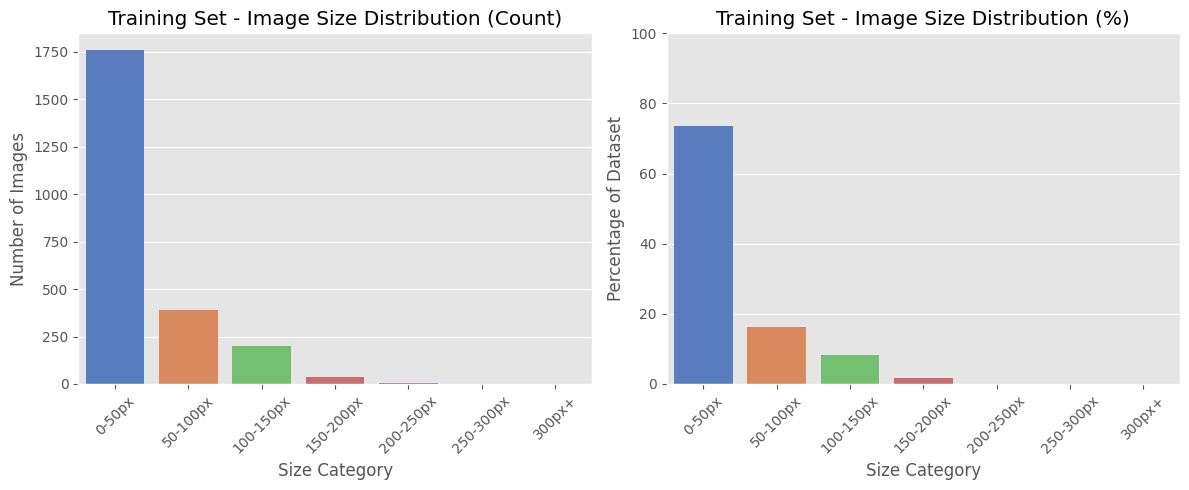

In [20]:
# Create side-by-side plots for Train Set
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Set - Count
sns.barplot(x=trainSizeDistribution.index, y=trainSizeDistribution.values, hue=trainSizeDistribution.index, palette="muted", ax=axes[0], legend=False)
axes[0].set_title("Training Set - Image Size Distribution (Count)")
axes[0].set_xlabel("Size Category")
axes[0].set_ylabel("Number of Images")
axes[0].set_xticks(range(len(trainSizeDistribution.index)))
axes[0].set_xticklabels(trainSizeDistribution.index, rotation=45)

# Training Set - Percentage
sns.barplot(x=trainSizeDistributionPercentage.index, y=trainSizeDistributionPercentage.values, hue=trainSizeDistributionPercentage.index, palette="muted", ax=axes[1], legend=False)
axes[1].set_title("Training Set - Image Size Distribution (%)")
axes[1].set_xlabel("Size Category")
axes[1].set_ylabel("Percentage of Dataset")
axes[1].set_ylim(0, 100)
axes[1].set_xticks(range(len(trainSizeDistributionPercentage.index)))
axes[1].set_xticklabels(trainSizeDistributionPercentage.index, rotation=45)

plt.tight_layout()
plt.show()


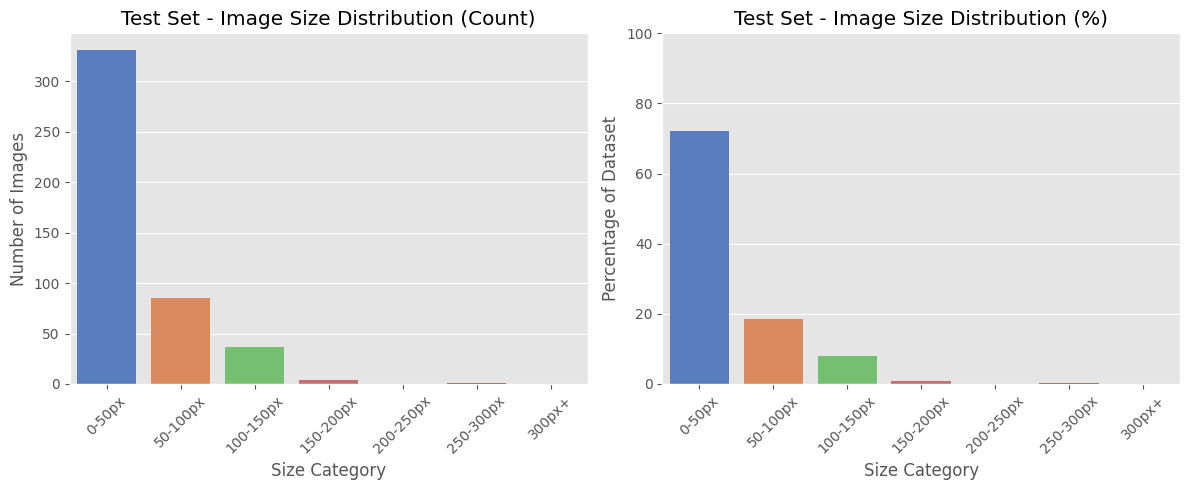

In [21]:
# Create side-by-side plots for Test Set
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Test Set - Count
sns.barplot(x=testSizeDistribution.index, y=testSizeDistribution.values, hue=testSizeDistribution.index, palette="muted", ax=axes[0], legend=False)
axes[0].set_title("Test Set - Image Size Distribution (Count)")
axes[0].set_xlabel("Size Category")
axes[0].set_ylabel("Number of Images")
axes[0].set_xticks(range(len(testSizeDistribution.index)))
axes[0].set_xticklabels(testSizeDistribution.index, rotation=45)

# Test Set - Percentage
sns.barplot(x=testSizeDistributionPercentage.index, y=testSizeDistributionPercentage.values, hue=testSizeDistributionPercentage.index, palette="muted", ax=axes[1], legend=False)
axes[1].set_title("Test Set - Image Size Distribution (%)")
axes[1].set_xlabel("Size Category")
axes[1].set_ylabel("Percentage of Dataset")
axes[1].set_ylim(0, 100)
axes[1].set_xticks(range(len(testSizeDistributionPercentage.index)))
axes[1].set_xticklabels(testSizeDistributionPercentage.index, rotation=45)

plt.tight_layout()
plt.show()
